<a href="https://colab.research.google.com/github/mechanic3000/GB_PyTorch_course/blob/Lesson_02/HW_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [1]:
# Сделаем необходимые импорты

import torch
import numpy as np

import torch.nn.functional as F
from torch import nn
import torchvision

from torch import optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt ### воспользуемся для отображения изображения

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10

transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_dataset = torchvision.datasets.CIFAR100(root='data/',
                                             train=True,  
                                             transform=transform, 
                                             download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True, pin_memory=True)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                         shuffle=False, pin_memory=True)

image, label = train_dataset[36]
print (image.size())
print (label)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified
torch.Size([3, 32, 32])
81


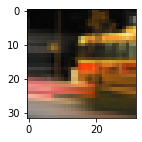

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(image.permute(1, 2, 0).numpy())

In [ ]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, но в ограничении на использование 
# линейные слои (пока без сверток)

# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации

In [5]:
import torch.nn.functional as F

class CustomLeakyRelu(nn.Module):
    def __init__(self, border:float, alpha:float) -> None:
        super().__init__()
        self.border = border
        self.alpha = alpha
        
    def forward(self, input):
        x = F.leaky_relu(input)
        return torch.where(x>self.border, x*self.alpha, x)


class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 15 * hidden_dim)
        self.fc2 = nn.Linear(15 * hidden_dim, 7 * hidden_dim)
        self.fc3 = nn.Linear(7 * hidden_dim, 2 * hidden_dim)
        self.fc4 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        self.cust_relu = CustomLeakyRelu(0.1, 0.5)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.cust_relu(x)
        x = self.fc2(x)
        x = self.cust_relu(x)
        x = self.fc3(x)
        x = self.cust_relu(x)
        x = self.fc4(x)
        x = self.cust_relu(x)
        x = self.fc5(x)
        # x = F.softmax(x)
        return x


net = Net(3072, 200, 100)

In [6]:
# Запустить обучение (по аналогии с тем, что делали на паре)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
for epoch in tqdm(range(30)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')

  0%|          | 0/30 [00:00<?, ?it/s]

[1,     1] loss: 0.002
[1,   301] loss: 0.662
[1,   601] loss: 0.611


  3%|▎         | 1/30 [02:37<1:16:10, 157.61s/it]

[2,     1] loss: 0.002
[2,   301] loss: 0.592
[2,   601] loss: 0.581


  7%|▋         | 2/30 [05:15<1:13:31, 157.55s/it]

[3,     1] loss: 0.002
[3,   301] loss: 0.564
[3,   601] loss: 0.554


 10%|█         | 3/30 [08:01<1:12:41, 161.53s/it]

[4,     1] loss: 0.002
[4,   301] loss: 0.537
[4,   601] loss: 0.534


 13%|█▎        | 4/30 [10:40<1:09:33, 160.51s/it]

[5,     1] loss: 0.002
[5,   301] loss: 0.521
[5,   601] loss: 0.515


 17%|█▋        | 5/30 [13:20<1:06:50, 160.42s/it]

[6,     1] loss: 0.002
[6,   301] loss: 0.505
[6,   601] loss: 0.506


 20%|██        | 6/30 [15:50<1:02:43, 156.81s/it]

[7,     1] loss: 0.002
[7,   301] loss: 0.491
[7,   601] loss: 0.494


 23%|██▎       | 7/30 [18:24<59:45, 155.88s/it]  

[8,     1] loss: 0.002
[8,   301] loss: 0.479
[8,   601] loss: 0.484


 27%|██▋       | 8/30 [20:55<56:35, 154.35s/it]

[9,     1] loss: 0.001
[9,   301] loss: 0.468
[9,   601] loss: 0.473


 30%|███       | 9/30 [23:27<53:47, 153.70s/it]

[10,     1] loss: 0.002
[10,   301] loss: 0.459
[10,   601] loss: 0.459


 33%|███▎      | 10/30 [26:03<51:29, 154.45s/it]

[11,     1] loss: 0.002
[11,   301] loss: 0.449
[11,   601] loss: 0.451


 37%|███▋      | 11/30 [28:39<49:03, 154.91s/it]

[12,     1] loss: 0.001
[12,   301] loss: 0.440
[12,   601] loss: 0.444


 40%|████      | 12/30 [31:14<46:26, 154.82s/it]

[13,     1] loss: 0.001
[13,   301] loss: 0.430
[13,   601] loss: 0.434


 43%|████▎     | 13/30 [33:49<43:53, 154.89s/it]

[14,     1] loss: 0.001
[14,   301] loss: 0.418
[14,   601] loss: 0.427


 47%|████▋     | 14/30 [36:25<41:22, 155.14s/it]

[15,     1] loss: 0.001
[15,   301] loss: 0.407
[15,   601] loss: 0.419


 50%|█████     | 15/30 [39:01<38:51, 155.44s/it]

[16,     1] loss: 0.001
[16,   301] loss: 0.400
[16,   601] loss: 0.404


 53%|█████▎    | 16/30 [41:34<36:07, 154.84s/it]

[17,     1] loss: 0.001
[17,   301] loss: 0.389
[17,   601] loss: 0.394


 57%|█████▋    | 17/30 [44:11<33:40, 155.44s/it]

[18,     1] loss: 0.001
[18,   301] loss: 0.375
[18,   601] loss: 0.385


 60%|██████    | 18/30 [46:48<31:09, 155.82s/it]

[19,     1] loss: 0.001
[19,   301] loss: 0.369
[19,   601] loss: 0.375


 63%|██████▎   | 19/30 [49:24<28:34, 155.83s/it]

[20,     1] loss: 0.001
[20,   301] loss: 0.354
[20,   601] loss: 0.367


 67%|██████▋   | 20/30 [52:03<26:09, 156.95s/it]

[21,     1] loss: 0.001
[21,   301] loss: 0.343
[21,   601] loss: 0.354


 70%|███████   | 21/30 [54:45<23:46, 158.52s/it]

[22,     1] loss: 0.001
[22,   301] loss: 0.332
[22,   601] loss: 0.343


 73%|███████▎  | 22/30 [57:22<21:04, 158.06s/it]

[23,     1] loss: 0.001
[23,   301] loss: 0.321
[23,   601] loss: 0.334


 77%|███████▋  | 23/30 [59:58<18:21, 157.30s/it]

[24,     1] loss: 0.001
[24,   301] loss: 0.307
[24,   601] loss: 0.324


 80%|████████  | 24/30 [1:02:36<15:46, 157.67s/it]

[25,     1] loss: 0.001
[25,   301] loss: 0.298
[25,   601] loss: 0.310


 83%|████████▎ | 25/30 [1:05:12<13:05, 157.01s/it]

[26,     1] loss: 0.001
[26,   301] loss: 0.287
[26,   601] loss: 0.299


 87%|████████▋ | 26/30 [1:07:46<10:25, 156.27s/it]

[27,     1] loss: 0.001
[27,   301] loss: 0.278
[27,   601] loss: 0.289


 90%|█████████ | 27/30 [1:10:20<07:46, 155.59s/it]

[28,     1] loss: 0.001
[28,   301] loss: 0.262
[28,   601] loss: 0.279


 93%|█████████▎| 28/30 [1:12:57<05:11, 155.81s/it]

[29,     1] loss: 0.001
[29,   301] loss: 0.252
[29,   601] loss: 0.267


 97%|█████████▋| 29/30 [1:15:34<02:36, 156.34s/it]

[30,     1] loss: 0.001
[30,   301] loss: 0.245
[30,   601] loss: 0.261


100%|██████████| 30/30 [1:18:10<00:00, 156.35s/it]

Training is finished!


In [8]:
PATH_MODEL = '/content/drive/MyDrive/Colab Notebooks/GB_pytorch/Lesson_02/model.pth'

In [9]:
torch.save(net, PATH_MODEL)

In [14]:
net = torch.load(PATH_MODEL)

In [10]:
data_iter = iter(test_loader)

In [21]:
images, labels = next(data_iter)

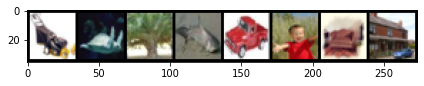

In [22]:
net.eval()
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(7,2))
plt.imshow(imgs.permute(1,2,0).numpy())

In [23]:
_, predicted = torch.max(outputs, 1)

In [24]:
gt = np.array([labels[j] for j in range(len(labels))])
pred = np.array([predicted[j] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum()/len(gt)}')

[41 93 56 73 58 11 25 37]
[41 73 47 33 32 45 94 90]
Accuracy is 0.125
